In [1]:
import MySQLdb
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score

from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline
plt.style.use('ggplot')

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

dsn = "mysql://root@localhost:3306/crunchbase"
conn = MySQLdb.connect(host="127.0.0.1", user="root", db="crunchbase")
tables = pd.read_sql("SHOW TABLES", con=conn)

######################################################################################


# We'll use this to adjust for inflation to 2017 USD
filepath = "../inflation.csv"
inflation = pd.read_csv(filepath)

inflation['DATE'] = pd.to_datetime(inflation.DATE)

funding_string = """
SELECT i.funding_round_id, i.investor_object_id, i.funded_object_id, 
f.raised_amount_usd, f.funded_at, f.funding_round_code
FROM cb_funding_rounds as f
INNER JOIN cb_investments as i
ON f.funding_round_id = i.funding_round_id
ORDER BY i.funding_round_id
"""
df_funding = pd.read_sql(funding_string, con=conn)

# Make this a datetime and a little clean up
df_funding['funded_at'] = pd.to_datetime(pd.Series(df_funding['funded_at']))
df_funding['funded_at'] = df_funding.funded_at.apply(lambda x: x.replace(day=1))

# Wayyyy too many funding codes. Let's put them into something a little simpler
df_funding['funding_round_code_clean'] = ['angel' if i == 'angel' else
                                          'seed' if i == 'seed' else
                                          'a' if i == 'a' else
                                          'b' if i == 'b' else
                                          'c' if i == 'c' else
                                          'series_d_above' if i == 'd' else 
                                          'series_d_above' if i == 'e' else 
                                          'series_d_above' if i == 'f' else 
                                          'series_d_above' if i == 'g' else
                                          'series_unknown' if i == 'unattributed' else
                                          'other' if i == 'partial' else 
                                          'other' if i == 'convertible' else 
                                          'other' if i == 'grant' else 
                                          'other' if i == 'crowd' else 
                                          'other' if i == 'debt_round' else
                                          'secondary_market' if i == 'private_equity' else 
                                          'secondary_market' if i == 'post_ipo_debt' else 
                                          'secondary_market' if i == 'post_ipo_equity' else 
                                          'secondary_market' if i == 'secondary_market' else
                                          i for i in df_funding['funding_round_code']]

# Much better. Let's get rid of this then.
del df_funding['funding_round_code']


# To be combined with a later dataframe
objects_string = """
SELECT id, normalized_name, name, category_code, status, founded_at, closed_at, 
funding_rounds, funding_total_usd FROM cb_objects
"""
df_objects = pd.read_sql(objects_string, con=conn)
df_objects['sector'] = df_objects['category_code']
del df_objects['category_code']

# Let's scale this
df_funding.raised_amount_usd /= df_funding.groupby(['funded_object_id', 
                                                    'funded_at']).raised_amount_usd.transform('count')
# To be used for timing
df_funding_timing = df_funding.merge(df_objects[['id', 'sector']], left_on='funded_object_id', right_on='id')




high_level = df_funding_timing.groupby(['funded_at']).agg({'raised_amount_usd': 'sum', 'funding_round_id': 'count'})
high_level = high_level.iloc[-108:].reset_index()
high_level.rename(columns={'funding_round_id':'number_of_investments'}, inplace=True)

adjusted_high_level = high_level.merge(inflation, left_on='funded_at', right_on='DATE')
adjusted_high_level.rename(columns={'CPIAUCSL_NBD20170101':'inflation'}, inplace=True)
del adjusted_high_level['DATE']
adjusted_high_level['num_diff'] = adjusted_high_level.number_of_investments.diff()

adjusted_high_level['current_USD']=adjusted_high_level.raised_amount_usd*(100/adjusted_high_level.inflation)
adjusted_high_level['rolling_annual_USD'] = adjusted_high_level.current_USD.rolling(window=12).mean()
adjusted_high_level['log_USD'] = np.log1p(adjusted_high_level.current_USD)
adjusted_high_level['minus_one'] = adjusted_high_level.log_USD.diff()
adjusted_high_level['rolling_annual_log_USD'] = adjusted_high_level.log_USD.rolling(window=12).mean()

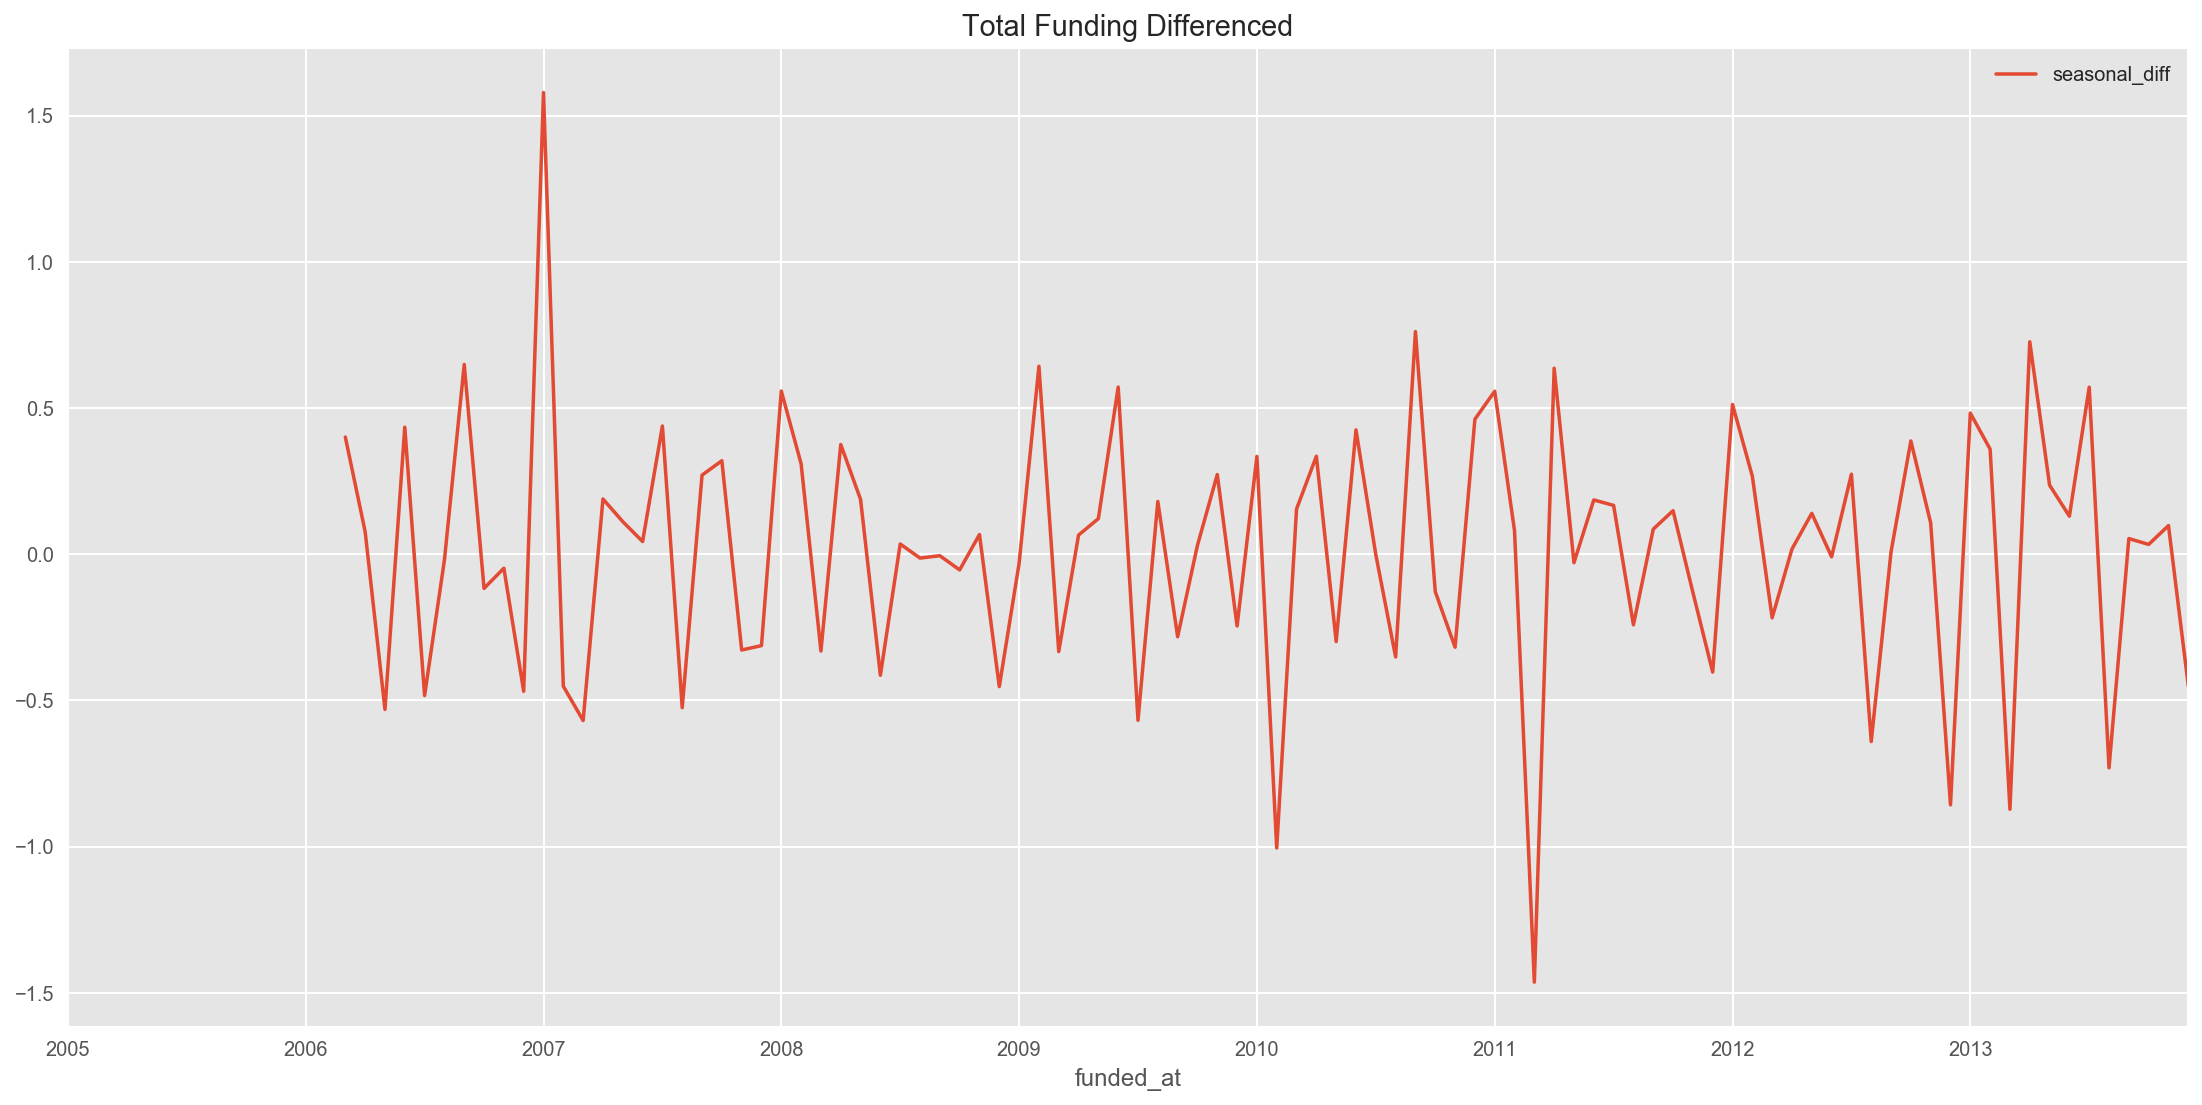

In [2]:
adjusted_high_level['shifted'] = adjusted_high_level.log_USD.shift(periods=13)
adjusted_high_level['diff_y'] = adjusted_high_level.shifted.diff()

# This 'seasonal' amount is from the Duke website given: Ŷt  =  (Yt-1) + (Yt-12) – (Yt-13)
adjusted_high_level['seasonal_diff'] = adjusted_high_level.minus_one + adjusted_high_level.diff_y

# From Analytics Vidhya
adjusted_high_level['log_MA'] = adjusted_high_level['log_USD'] - adjusted_high_level['rolling_annual_log_USD']

adjusted_high_level.index = adjusted_high_level['funded_at'].values

In [5]:
del adjusted_high_level['funded_at']
del adjusted_high_level['num_diff']
del adjusted_high_level['log_MA']
del adjusted_high_level['rolling_annual_log_USD']
del adjusted_high_level['rolling_annual_USD']
del adjusted_high_level['number_of_investments']
del adjusted_high_level['raised_amount_usd']

In [9]:
adjusted_high_level.head(15)

,inflation,current_USD,log_USD,minus_one,shifted,diff_y,seasonal_diff
2005-01-01,78.47378,1.607392e+09,21.197879,NaN,NaN,NaN,NaN
2005-02-01,78.80143,1.495108e+09,21.125464,-0.072415,NaN,NaN,NaN
2005-03-01,79.08813,1.557594e+09,21.166408,0.040944,NaN,NaN,NaN
2005-04-01,79.33387,1.137798e+09,20.852360,-0.314048,NaN,NaN,NaN
2005-05-01,79.29292,1.259300e+09,20.953822,0.101462,NaN,NaN,NaN
2005-06-01,79.33387,1.132403e+09,20.847608,-0.106214,NaN,NaN,NaN
2005-07-01,79.82536,1.013422e+09,20.736598,-0.111009,NaN,NaN,NaN
2005-08-01,80.31684,1.513429e+09,21.137644,0.401045,NaN,NaN,NaN
2005-09-01,81.42269,1.480894e+09,21.115912,-0.021731,NaN,NaN,NaN
2005-10-01,81.54556,1.471917e+09,21.109831,-0.006081,NaN,NaN,NaN
